# **Optimising Twenty One and pontoon :**



###Actions = 1(hit) / 0(stick),  Reward = +1 ,-1 ,0 (win,lost,draw)

In [ ]:
import gym
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
from collections import defaultdict
from IPython.display import clear_output
%matplotlib inline

In [ ]:
env = gym.make('Blackjack-v1')

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# ob1 = env
# ob1

The states are stored in this tuple format:

(Agent's score , Dealer's visible score, and whether or not the agent has a usable ace) -  Usable ace - accounts for 11 no usable ace if - 1 

In [ ]:
env.observation_space #state space #(player's score in hand,dealer's score and usable/not usable ace)

Tuple(Discrete(32), Discrete(11), Discrete(2))

The agent only has 2 options: Hit(1) or Stay(0).

In [ ]:
env.action_space.n # No.of actions in the environment 

2

Let's view one scenario.

In [ ]:
ob = env.reset()
ob

(19, 10, True)

In [ ]:
visible = "" if ob[2] else "no"
print("The above shows that the player's hand has a total sum of " 
      + str(ob[0]) + " while the dealer visible hand is " 
      + str(ob[1]) + " and that the player has " + visible + " usable ace")

The above shows that the player's hand has a total sum of 19 while the dealer visible hand is 10 and that the player has  usable ace


Let's assume the player's first action would be to "hit" (Action step would be 1). The following would occur.

In [ ]:
env.step(1) #tuple,reward,game ended or no

((19, 10, False), 0.0, False, {})

In [ ]:
ob = env.reset()
ob

(15, 8, False)

Assume the next action would be to stay.

In [ ]:
env.step(0) #reward = -1 dealer won player lost

((15, 8, False), -1.0, True, {'TimeLimit.truncated': False})

In [ ]:
env.dealer #dealer's hand

[8, 6, 3]

The current strategy is to draw cards as long as he has a score of below 17.

**2. Basic Naive Strategy**

Let's start by testing out a basic strategy which is to **Draw as long as the score is below 17** and calculate the average payoff.

In [ ]:
def draw_till_17_pol(obs):
    if obs[0]<17:
      print("draw/hit")   #[0,1] [hit,stick]
      return [0,1] 
    else:     #policy <17 then we hit or we stick
      print("stick")
      return [1,0]

def calc_payoffs(env,ob,rounds,players,pol):
    ob1 = ob
    print(ob1)
    average_payouts = []
    for player in range(players):
        rd = 1
        total_payout = 0 # to store total payout over 'num_rounds'

        while rd <= rounds:
            print("Player :",player," and round :",rd)
            # action1 = pol(ob1)
            # print("Dealer's hand :",env.dealer)
            print(ob1)
            action = np.argmax(pol(ob1)) #returns index
            # print(action1)
            print(action)
            ob1, payout, is_done, _ = env.step(action)  #env.step(1) similar to player drawing a card so sum will increase -- env.step(0) is opposite
            print(ob1,payout,is_done)
            if is_done:
                total_payout += payout
                ob1 = env.reset() # Environment deals new cards to player and dealer
                rd += 1
        average_payouts.append(total_payout)

    plt.plot(average_payouts)                
    plt.xlabel('num_player')
    plt.ylabel('payout after ' + str(rounds) + 'rounds')
    plt.show()    
    print ("Average payout of a player after {} rounds is {}".format(rounds, sum(average_payouts)/players))

(12, 8, False)
Player : 0  and round : 1
Dealer's hand : [8, 6]
(12, 8, False)
draw/hit
1
(19, 8, False) 0.0 False
Player : 0  and round : 1
Dealer's hand : [8, 6]
(19, 8, False)
stick
0
(19, 8, False) 1.0 True
Player : 0  and round : 2
Dealer's hand : [2, 10]
(12, 2, False)
draw/hit
1
(16, 2, False) 0.0 False
Player : 0  and round : 2
Dealer's hand : [2, 10]
(16, 2, False)
draw/hit
1
(25, 2, False) -1.0 True
Player : 0  and round : 3
Dealer's hand : [3, 3]
(17, 3, False)
stick
0
(17, 3, False) -1.0 True
Player : 0  and round : 4
Dealer's hand : [6, 4]
(15, 6, True)
draw/hit
1
(12, 6, False) 0.0 False
Player : 0  and round : 4
Dealer's hand : [6, 4]
(12, 6, False)
draw/hit
1
(20, 6, False) 0.0 False
Player : 0  and round : 4
Dealer's hand : [6, 4]
(20, 6, False)
stick
0
(20, 6, False) 0.0 True
Player : 0  and round : 5
Dealer's hand : [5, 6]
(20, 5, False)
stick
0
(20, 5, False) 1.0 True
Player : 0  and round : 6
Dealer's hand : [2, 6]
(12, 2, False)
draw/hit
1
(22, 2, False) -1.0 True

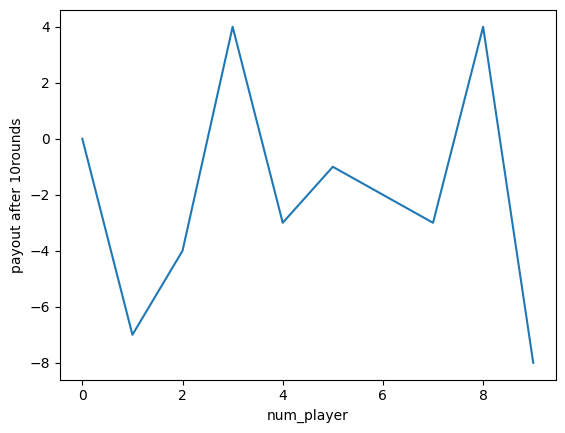

Average payout of a player after 10 rounds is -2.0


In [ ]:
env = gym.make('Blackjack-v1')
ob1 = env.reset()
calc_payoffs(env,ob1,10,10,draw_till_17_pol)

**3. Monte Carlo Method**

Let's first define some function to plot our policy and value function.

In [ ]:
def plot_value_function(V, title="Value Function"):

    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))


**3.1 MC (On-Policy) --> Learn from the top**

In [ ]:
def create_epsilon_greedy_action_policy(env,Q,epsilon): 
    """ Create epsilon greedy action policy - function returns a policy function that takes observations of env as input 
    and outputs probabilities of taking each action in that state - it returns the probability distribution over all actions in that state
    """
    # print("create_epsilon_greedy_action_policy")
    def policy(obs):
        # print("ploicy")
        # print(obs,"true")
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n  #initiate with same prob for all actions = epsilon / no.of actions
        best_action = np.argmax(Q[obs])  #get best action
        # print(best_action)
        P[best_action] += (1.0 - epsilon) # and increases its probability by 1-epsilon
        print("P",P)
        return P
    # print("policy",policy)
    return policy

In [ ]:
def On_pol_mc_control_learn(env,ob1, episodes, discount_factor, epsilon):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy for a given environment.
    """
    # Keeps track of sum and count of returns for each state
    # defaultdict used so that the default value is stated if the observation(key) is not found
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q-table dictionary keys- state and action  values - initialized to all zeroes
    
    # The policy we're following 
    # print("check1")
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)
    for i in range(1, episodes + 1):
        # Print out which episode we're on
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            # clear_output(wait=True)

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # print("State next obs:",state)
            probs = pol(state) #calls the policy function assigned from greedy epsilon polciy - to select an action using an epsilon-greedy policy based on the current Q table
            action = np.random.choice(np.arange(len(probs)), p=probs)
            # print(state,action) #
            next_state, reward, done, _ = env.step(action)
            # print(next_state, reward, done, _) #
            episode.append((state, action, reward)) #state-action pair and the corresponding reward stored in a list - episode
            print("Epsiode :",episode)
            if done:
                break
            state = next_state 
        '''
          function updates the Q table using the Monte Carlo update rule - It goes through each state-action pair in the episode 
          and updates the Q value by averaging the returns for that pair.
          We convert each state to a tuple so that we can use it as a dict key
        '''
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            #First Visit MC: 
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # fvmc -The returns for each pair are calculated as the sum of rewards from that pair to the end of the episode multiplied by the discount factor
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    
    return Q, pol

In [ ]:
#returns the learned Q table and the learned policy function
env = gym.make('Blackjack-v1')
ob1 = env.reset()
Q_on_pol,On_MC_Learned_Policy = On_pol_mc_control_learn(env,ob1, 5000, 0.9, 0.05)


Streaming output truncated to the last 5000 lines.
Epsiode : [((14, 7, False), 0, 1.0)]
Epsiode : [((9, 4, False), 1, 0.0)]
Epsiode : [((9, 4, False), 1, 0.0), ((20, 4, True), 0, 1.0)]
Epsiode : [((18, 1, False), 0, -1.0)]
Epsiode : [((10, 10, False), 1, 0.0)]
Epsiode : [((10, 10, False), 1, 0.0), ((14, 10, False), 0, -1.0)]
Epsiode : [((12, 4, False), 1, 0.0)]
Epsiode : [((12, 4, False), 1, 0.0), ((14, 4, False), 0, -1.0)]
Epsiode : [((10, 6, False), 0, 1.0)]
Epsiode : [((12, 10, False), 0, -1.0)]
Epsiode : [((12, 10, False), 0, -1.0)]
Epsiode : [((20, 7, True), 0, 0.0)]
Epsiode : [((18, 10, False), 0, -1.0)]
Epsiode : [((5, 5, False), 0, -1.0)]
Epsiode : [((10, 7, False), 1, 0.0)]
Epsiode : [((10, 7, False), 1, 0.0), ((20, 7, False), 0, 1.0)]
Epsiode : [((12, 6, False), 0, 1.0)]
Epsiode : [((21, 9, True), 0, 1.0)]
Epsiode : [((20, 8, False), 0, 1.0)]
Epsiode : [((12, 10, True), 1, 0.0)]
Epsiode : [((12, 10, True), 1, 0.0), ((19, 10, True), 1, 0.0)]
Epsiode : [((12, 10, True), 1, 0.0)

In [ ]:
# print("Q_table :", Q_on_pol)

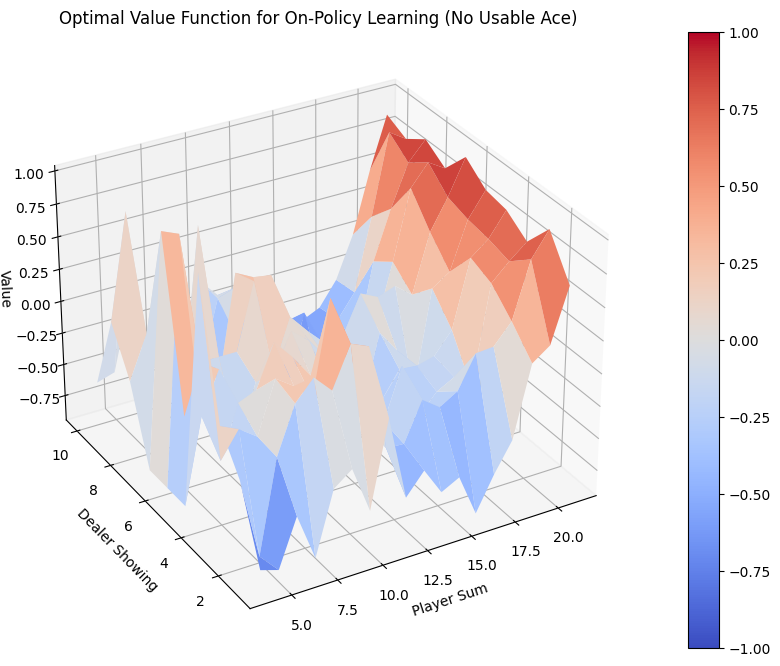

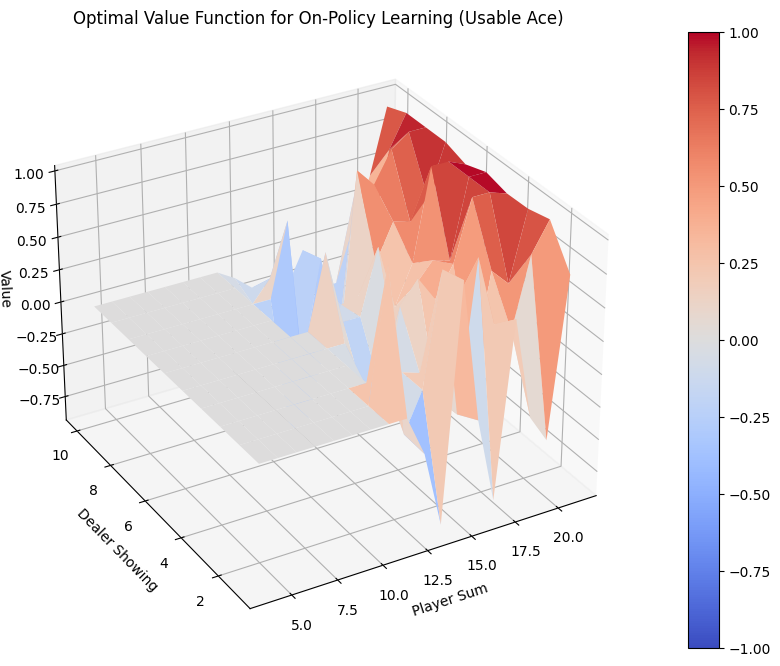

defaultdict(<class 'float'>, {(11, 10, False): -0.1834177215189874, (19, 8, False): 0.4418604651162791, (8, 8, False): 0.15000000000000002, (7, 4, False): 0.012857142857142853, (21, 10, True): 0.94, (14, 10, False): -0.49625, (12, 6, False): 0.0, (21, 1, True): 0.7142857142857143, (20, 10, False): 0.47474747474747475, (16, 6, False): 0.1111111111111111, (9, 1, False): -0.26, (21, 3, True): 0.96, (12, 1, False): -0.6089210526315788, (20, 6, False): 0.7307692307692307, (9, 4, False): 0.18000000000000002, (9, 10, False): -0.273, (9, 3, False): 0.0, (20, 4, False): 0.6511627906976745, (12, 10, False): -0.6781609195402298, (12, 5, False): -0.08322580645161287, (13, 5, False): -0.10805555555555556, (10, 8, False): -0.21564, (10, 10, False): -0.037826086956521746, (15, 10, False): -0.5510169491525425, (10, 1, False): -0.6230769230769232, (7, 5, False): -0.522, (15, 4, False): -0.15384615384615385, (19, 5, False): 0.3157894736842105, (17, 5, True): 0.29, (17, 10, False): -0.5158730158730159, (

In [ ]:
'''
keys are the states of the game in the Blackjack-v1 environment and the values are the corresponding optimal values of the states - 
For each state, the code finds the optimal action by selecting the action that has the highest Q-value in that state, 
and then assigns the value of that action to the state in V
'''
V = defaultdict(float)
for state, actions in Q_on_pol.items():
    action_value = np.max(actions)
    V[state] = action_value 
plot_value_function(V, title="Optimal Value Function for On-Policy Learning")
print(V)

In [ ]:
on_pol = {key: np.argmax(On_MC_Learned_Policy(key)) for key in Q_on_pol.keys()}
print("On-Policy MC Learning Policy")

In [ ]:
on_pol

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{(11, 10, False): 1,
 (19, 8, False): 0,
 (8, 8, False): 1,
 (7, 4, False): 1,
 (21, 10, True): 0,
 (14, 10, False): 1,
 (12, 6, False): 0,
 (21, 1, True): 0,
 (20, 10, False): 0,
 (16, 6, False): 0,
 (9, 1, False): 1,
 (21, 3, True): 0,
 (12, 1, False): 1,
 (20, 6, False): 0,
 (9, 4, False): 1,
 (9, 10, False): 1,
 (9, 3, False): 1,
 (20, 4, False): 0,
 (12, 10, False): 0,
 (12, 5, False): 1,
 (13, 5, False): 1,
 (10, 8, False): 1,
 (10, 10, False): 1,
 (15, 10, False): 1,
 (10, 1, False): 1,
 (7, 5, False): 1,
 (15, 4, False): 0,
 (19, 5, False): 0,
 (17, 5, True): 1,
 (17, 10, False): 0,
 (12, 8, False): 1,
 (7, 2, False): 1,
 (17, 2, True): 1,
 (16, 8, False): 0,
 (13, 10, False): 1,
 (17, 8, True): 1,
 (16, 4, True): 1,
 (14, 4, False): 0,
 (11, 2, False): 1,
 (20, 4, True): 0,
 (14, 2, False): 0,
 (17, 5, False): 1,
 (18, 10, False): 0,
 (18, 1, False): 0,
 (7, 10, False): 0,
 (12, 10, True): 1,
 (14, 5, False): 1,
 (13, 9, False): 0,
 (9, 2, False): 1,
 (10, 5, False): 1,
 (13, 

(21, 1, True)
Player : 0  and round : 1
Dealer's hand : [1, 10]
(21, 1, True)
0
(21, 1, True) 0.0 True
Player : 0  and round : 2
Dealer's hand : [9, 9]
(8, 9, False)
0
(8, 9, False) -1.0 True
Player : 0  and round : 3
Dealer's hand : [6, 4]
(13, 6, False)
0
(13, 6, False) -1.0 True
Player : 0  and round : 4
Dealer's hand : [2, 10]
(13, 2, False)
0
(13, 2, False) -1.0 True
Player : 0  and round : 5
Dealer's hand : [10, 10]
(17, 10, False)
0
(17, 10, False) -1.0 True
Player : 0  and round : 6
Dealer's hand : [7, 1]
(19, 7, False)
0
(19, 7, False) 1.0 True
Player : 0  and round : 7
Dealer's hand : [4, 10]
(15, 4, False)
0
(15, 4, False) 1.0 True
Player : 0  and round : 8
Dealer's hand : [5, 2]
(20, 5, False)
0
(20, 5, False) 1.0 True
Player : 0  and round : 9
Dealer's hand : [10, 10]
(17, 10, False)
0
(17, 10, False) -1.0 True
Player : 0  and round : 10
Dealer's hand : [2, 10]
(15, 2, False)
1
(23, 2, False) -1.0 True
Player : 1  and round : 1
Dealer's hand : [5, 10]
(19, 5, True)
1
(21, 

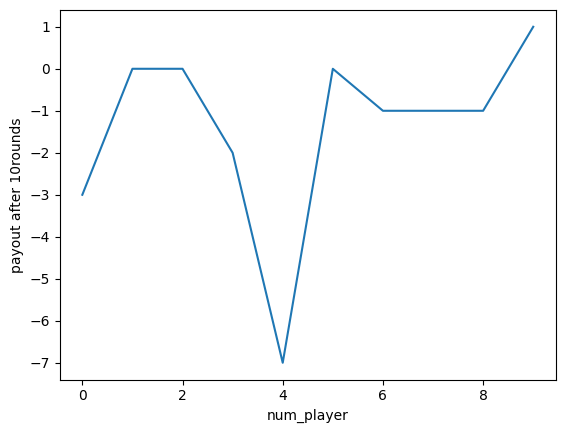

Average payout of a player after 10 rounds is -1.4


In [ ]:
'''
Payoff for On-Policy MC Trained Policy - the learned policy and also calculate the average payoffs for players over two rounds using the learned policy
'''
ob1 = env.reset()
calc_payoffs(env,ob1,10,10,On_MC_Learned_Policy)

**3.2 MC (Off-Policy) --> Learn from the tail**

In [ ]:

def create_random_policy(nA): #The create_random_policy function creates a random policy that returns a vector of equal probabilities for each action
    
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(obs):
        return A
    return policy_fn
def create_greedy_action_policy(env,Q): #creates a greedy action policy that selects the action with the highest Q-value for a given state
    """ Create greedy action policy
    Args:
        env: Environment
        Q: Q table
    
    Returns:
        Greedy-action Policy function 
    """
    def policy(obs):
        P = np.zeros_like(Q[obs], dtype=float)
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] = 1
        return P
    return policy


In [ ]:
def Off_pol_mc_control_learn(env, obs1, num_episodes, policy, discount_factor):

    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedy policy 
    target_policy = create_greedy_action_policy(env,Q)
        
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            clear_output(wait=True)

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = target_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula 
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the policy is not the action taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./policy(state)[action]
        
    return Q, target_policy

In [ ]:
'''
The code runs Monte Carlo Control Off-Policy Control using Weighted Importance Sampling to find an optimal greedy policy in the Blackjack environment. 
It uses a random policy to generate episodes and learns the Q-value function and the optimal greedy policy using the weighted importance sampling method.
The code runs for 500,000 episodes and returns the Q-value function and the optimal greedy policy.
'''
env = gym.make('Blackjack-v1')
obs1 = env.reset()
rand = create_random_policy(env.action_space.n)
Q_off_Pol,off_MC_Learned_Policy = Off_pol_mc_control_learn(env,obs1, 5000, rand,0.9)

Episode 5000/5000.

(19, 5, False)
Player : 0  and round : 1
Dealer's hand : [5, 10]
(19, 5, False)
0
(19, 5, False) 1.0 True
Player : 0  and round : 2
Dealer's hand : [6, 4]
(16, 6, False)
0
(16, 6, False) 1.0 True
Player : 0  and round : 3
Dealer's hand : [5, 9]
(18, 5, False)
0
(18, 5, False) 1.0 True
Player : 0  and round : 4
Dealer's hand : [8, 2]
(18, 8, True)
1
(17, 8, False) 0.0 False
Player : 0  and round : 4
Dealer's hand : [8, 2]
(17, 8, False)
0
(17, 8, False) -1.0 True
Player : 0  and round : 5
Dealer's hand : [5, 1]
(21, 5, True)
0
(21, 5, True) 1.0 True
Player : 0  and round : 6
Dealer's hand : [6, 8]
(17, 6, False)
0
(17, 6, False) -1.0 True
Player : 0  and round : 7
Dealer's hand : [3, 2]
(15, 3, False)
1
(25, 3, False) -1.0 True
Player : 0  and round : 8
Dealer's hand : [10, 8]
(10, 10, False)
1
(15, 10, False) 0.0 False
Player : 0  and round : 8
Dealer's hand : [10, 8]
(15, 10, False)
0
(15, 10, False) -1.0 True
Player : 0  and round : 9
Dealer's hand : [4, 2]
(7, 4, False)
1
(9, 4, Fal

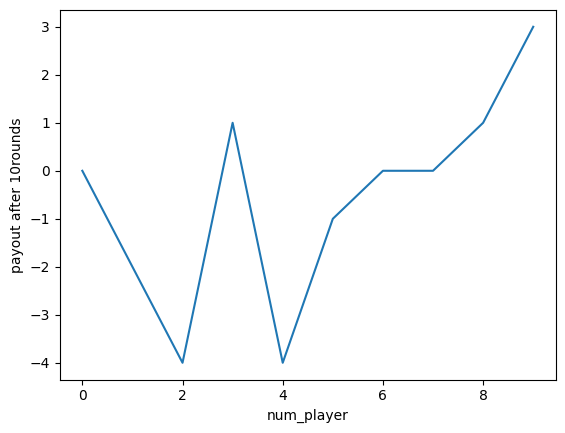

Average payout of a player after 10 rounds is -0.6


In [ ]:
#Payoff for Off-Policy MC Trained Policy
ob1 = env.reset()
calc_payoffs(env,ob1,10,10,off_MC_Learned_Policy)

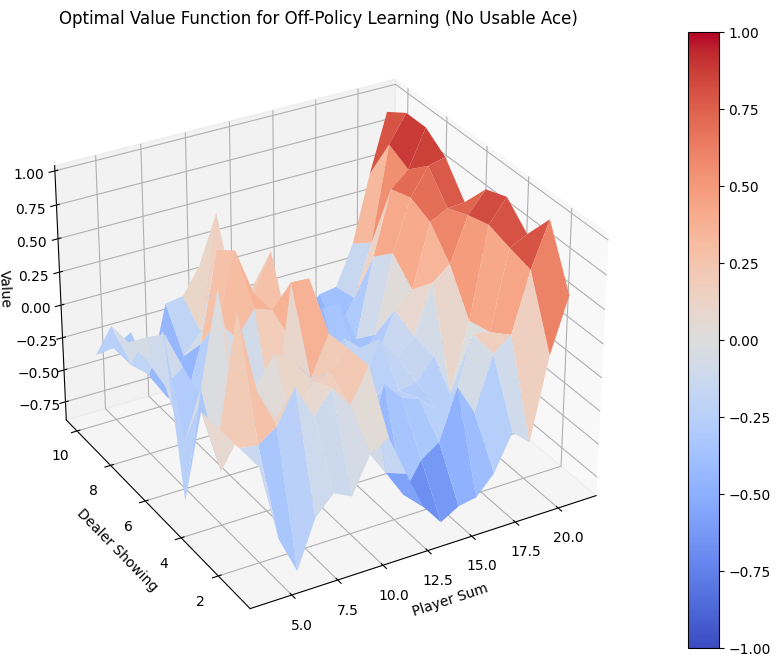

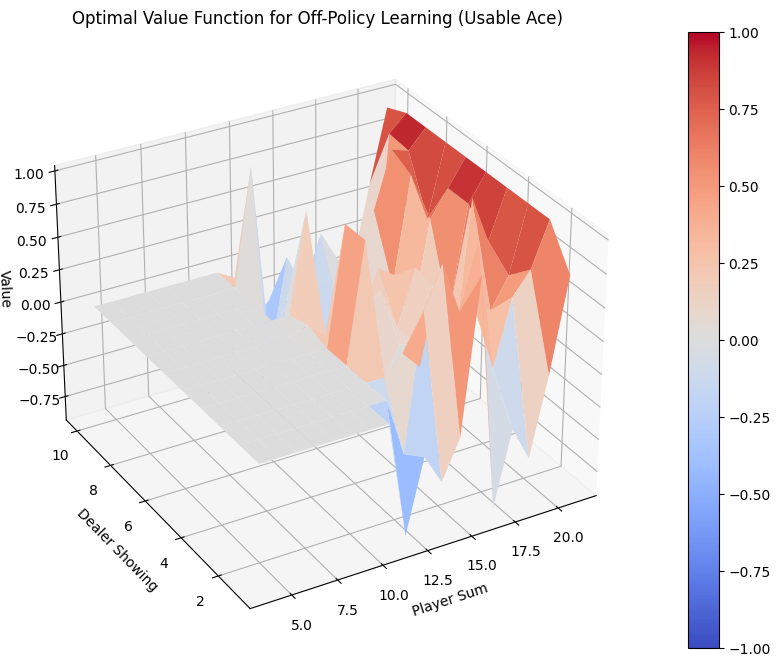

In [ ]:
V = defaultdict(float)
for state, actions in Q_off_Pol.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function for Off-Policy Learning")

# **4. TD Learning**

## **4.1 SARSA Learning**

In [ ]:
def create_epsilon_greedy_action_policy(env,Q,epsilon):

    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n  #initiate with same prob for all actions
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] += (1.0 - epsilon)
        return P
    return policy
def SARSA(env, ob1,episodes, epsilon, alpha, gamma):
    # Initialise a dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The policy we're following
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)
    for i in range(1, episodes + 1):
        # Print out which episode we're on
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)
        curr_state = env.reset()
        probs = pol(curr_state)   #get epsilon greedy policy
        # print(probs)
        curr_act = np.random.choice(np.arange(len(probs)), p=probs)
        while True:
            next_state,reward,done,_ = env.step(curr_act)
            next_probs = create_epsilon_greedy_action_policy(env,Q,epsilon)(next_state)
            next_act = np.random.choice(np.arange(len(next_probs)),p=next_probs)
            ## td formula 
            td_target = reward + gamma * Q[next_state][curr_act]
            td_error = td_target - Q[curr_state][curr_act]
            Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
            if done:
                break
            curr_state = next_state
            curr_act = next_act
    return Q, pol

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make('Blackjack-v1')
ob1 = env.reset()
Q_SARSA,SARSA_Policy = SARSA(env,ob1,5000, 0.1, 0.1,0.95)

(14, 2, False)
Player : 0  and round : 1
Dealer's hand : [2, 10]
(14, 2, False)
1
(18, 2, False) 0.0 False
Player : 0  and round : 1
Dealer's hand : [2, 10]
(18, 2, False)
0
(18, 2, False) 0.0 True
Player : 0  and round : 2
Dealer's hand : [2, 9]
(17, 2, False)
1
(21, 2, False) 0.0 False
Player : 0  and round : 2
Dealer's hand : [2, 9]
(21, 2, False)
0
(21, 2, False) 1.0 True
Player : 0  and round : 3
Dealer's hand : [1, 10]
(20, 1, False)
0
(20, 1, False) -1.0 True
Player : 0  and round : 4
Dealer's hand : [10, 7]
(18, 10, False)
1
(21, 10, False) 0.0 False
Player : 0  and round : 4
Dealer's hand : [10, 7]
(21, 10, False)
0
(21, 10, False) 1.0 True
Player : 0  and round : 5
Dealer's hand : [8, 10]
(11, 8, False)
0
(11, 8, False) -1.0 True
Player : 0  and round : 6
Dealer's hand : [8, 8]
(17, 8, False)
1
(22, 8, False) -1.0 True
Player : 0  and round : 7
Dealer's hand : [2, 2]
(12, 2, False)
0
(12, 2, False) 1.0 True
Player : 0  and round : 8
Dealer's hand : [5, 6]
(21, 5, True)
0
(21,

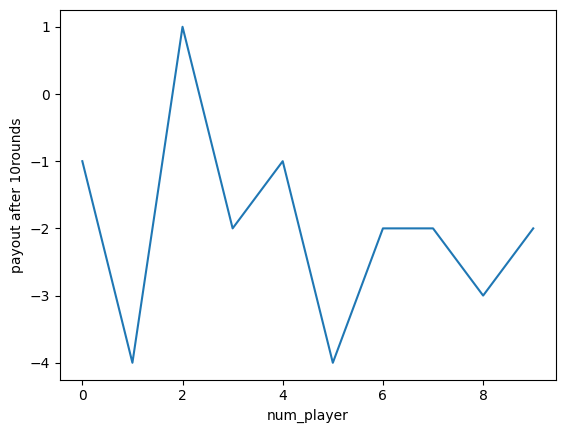

Average payout of a player after 10 rounds is -2.0


In [ ]:
#Payoff for Off-Policy MC Trained Policy
ob1 = env.reset()
calc_payoffs(env,ob1,10,10,SARSA_Policy)

In [ ]:
pol_sarsa = {key: np.argmax(SARSA_Policy(key)) for key in Q_SARSA.keys()}
print("SARSA Learning Policy")

SARSA Learning Policy


**4.2 Q-Learning: Off-Policy TD**

In [ ]:
def off_pol_TD_Q_learn(env, ob1,episodes, epsilon, alpha, gamma):
    # Initialise a dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The policy we're following
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)
    for i in range(1, episodes + 1):
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)
        curr_state = env.reset()
        while True:
            probs = pol(curr_state)   #get epsilon greedy policy
            curr_act = np.random.choice(np.arange(len(probs)), p=probs)
            next_state,reward,done,_ = env.step(curr_act)
            next_act = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][next_act]
            td_error = td_target - Q[curr_state][curr_act]
            Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
            if done:
                break
            curr_state = next_state
    return Q, pol

In [ ]:
env = gym.make('Blackjack-v1')
ob1 = env.reset()
Q_QLearn,QLearn_Policy = off_pol_TD_Q_learn(env,ob1, 5000, 0.1, 0.1,0.95)

Episode 5000/5000.

(18, 3, False)
Player : 0  and round : 1
Dealer's hand : [3, 9]
(18, 3, False)
0
(18, 3, False) -1.0 True
Player : 0  and round : 2
Dealer's hand : [10, 6]
(5, 10, False)
1
(15, 10, False) 0.0 False
Player : 0  and round : 2
Dealer's hand : [10, 6]
(15, 10, False)
1
(23, 10, False) -1.0 True
Player : 0  and round : 3
Dealer's hand : [3, 4]
(13, 3, False)
1
(23, 3, False) -1.0 True
Player : 0  and round : 4
Dealer's hand : [6, 10]
(13, 6, False)
1
(17, 6, False) 0.0 False
Player : 0  and round : 4
Dealer's hand : [6, 10]
(17, 6, False)
1
(19, 6, False) 0.0 False
Player : 0  and round : 4
Dealer's hand : [6, 10]
(19, 6, False)
0
(19, 6, False) 0.0 True
Player : 0  and round : 5
Dealer's hand : [1, 6]
(20, 1, False)
0
(20, 1, False) 1.0 True
Player : 0  and round : 6
Dealer's hand : [5, 10]
(8, 5, False)
1
(10, 5, False) 0.0 False
Player : 0  and round : 6
Dealer's hand : [5, 10]
(10, 5, False)
1
(20, 5, False) 0.0 False
Player : 0  and round : 6
Dealer's hand : [5, 10]
(20, 5, False)
0
(

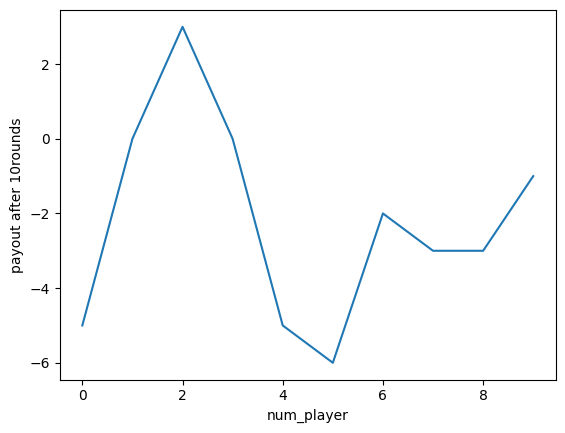

Average payout of a player after 10 rounds is -2.2


In [ ]:
#Payoff for Off-Policy Q-Learning Trained Policy
ob1 = env.reset()
calc_payoffs(env,ob1, 10,10,QLearn_Policy)

In [ ]:
pol_QLearn = {key: np.argmax(QLearn_Policy(key)) for key in Q_QLearn.keys()}
print("Off-Policy Q Learning Policy")

Off-Policy Q Learning Policy
